Bilder pro Sekunde
 ======
 
 Mit diesem Python Notebook ist es möglich, dass zeitliche Verhalten einer Serienaufnahme der Android Anwendung "Fahrradwege Monotring App" zu untersuchen.  
 Ziel ist es zu berechnen wie viele Bilder in einer Serienaufnahme pro Sekunde aufgenommen wurden.  
 Des Weiteren ist es möglich die längste Zeitspanne zwischen  zwei Aufnahmen innerhalb einer Serienaufnahme zu ermitteln.
 

Bilder pro Sekunde in einer Serienaufnahme

Um die Anzahl der Bilder pro Sekunde zu berechnen ist es wichtig, dass diese kontinuierlich in kurzen Zeitabschnitten  
aufgenommen wurden. In der Android habe ich einen Schwellenwert implementiert damit keine Aufnahmen gemacht werden,  
wenn eine bestimmte Geschwindikeit nicht überschritten wurde. Dies ist relevant um keine Aufnahme zu machen falls  
ein Fahrrad steht während die Anwendung läuft.

In [1]:
import pandas 
import math
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Startindex der Features eines Fotos   
startIndex = 0
# Stop Index 
stopIndex = 100000
# Öfnne die Datei features.csv. Der Path muss mit angegeben werden
featuresDf = pandas.read_csv(filepath_or_buffer="../daten/merkmale_datensatz_40/merkmaleRoh.csv")

In [3]:
featuresDf.describe()

,Zeitstempel in Unixzeit,Breitengrad,Laengengrad,Geschwindigkeit in km/h,Anzahl der Messwerte,Start des Zeitfensters in ns seit Start der JVM,Zeitstempel Messwertdaten anfordern in Unixzeit,Start der Messwerterfassung in ns seit Start der JVM,Erster Zeitstempel der Teilliste in ns seit Start der JVM,Start der Belichtung in ns seit Start der JVM,Belichtungszeit in ns,Letzter Zeitstempel der Messwerterfassung in ns seit Start der JVM,Speicherzeitpunkt der Merkmale in Unixzeit
count,2.182900e+04,21829.000000,21829.000000,21829.000000,21829.000000,2.182900e+04,2.182900e+04,2.182900e+04,2.182900e+04,2.182900e+04,2.182900e+04,2.182900e+04,2.182900e+04
mean,1.527349e+12,53.652962,10.199540,15.239831,31.050804,1.119847e+13,1.527349e+12,1.117817e+13,1.119784e+13,1.119859e+13,1.005287e+07,1.119874e+13,1.527349e+12
std,2.911810e+06,0.022920,0.030768,3.750156,10.818663,2.901933e+12,2.911809e+06,2.902658e+12,2.901949e+12,2.901932e+12,1.036197e+07,2.901934e+12,2.911809e+06
min,1.527344e+12,53.613163,10.137853,5.004000,16.000000,6.094821e+12,1.527344e+12,6.094619e+12,6.094619e+12,6.095142e+12,7.905860e+05,6.095505e+12,1.527344e+12
25%,1.527347e+12,53.633210,10.168057,12.887999,24.000000,8.689469e+12,1.527347e+12,8.680375e+12,8.688955e+12,8.689580e+12,2.224673e+06,8.689711e+12,1.527347e+12
50%,1.527349e+12,53.654457,10.207479,15.696000,28.000000,1.115951e+13,1.527349e+12,1.112681e+13,1.115901e+13,1.115963e+13,3.787461e+06,1.115978e+13,1.527349e+12
75%,1.527352e+12,53.675587,10.227845,17.856000,34.000000,1.397875e+13,1.527352e+12,1.394888e+13,1.397737e+13,1.397903e+13,2.000368e+07,1.397932e+13,1.527352e+12
max,1.527354e+12,53.687490,10.242206,25.775997,90.000000,1.592728e+13,1.527354e+12,1.591365e+13,1.592662e+13,1.592758e+13,2.999632e+07,1.592791e+13,1.527354e+12


In [4]:
# Andzahl der Einträge
featuresDf.index

RangeIndex(start=0, stop=21829, step=1)

In [5]:
# Namen der Spalten 
featuresDf.columns

Index(['Zeitstempel in Unixzeit', 'Breitengrad', 'Laengengrad',
       'Geschwindigkeit in km/h', 'Z-Achse Beschleunigungswerte in m/s^2',
       'Y-Achse Beschleunigungswerte in m/s^2', 'Nick Messwerte in rad',
       'Zeitstempel der Messwerte in ns', 'Anzahl der Messwerte',
       'Start des Zeitfensters in ns seit Start der JVM',
       'Zeitstempel Messwertdaten anfordern in Unixzeit',
       'Start der Messwerterfassung in ns seit Start der JVM',
       'Erster Zeitstempel der Teilliste in ns seit Start der JVM',
       'Start der Belichtung in ns seit Start der JVM',
       'Belichtungszeit in ns',
       'Letzter Zeitstempel der Messwerterfassung in ns seit Start der JVM',
       'Speicherzeitpunkt der Merkmale in Unixzeit'],
      dtype='object')

In [6]:
# Für den Plot der Bilder pro Sekunde 
imagesPerSecondList = []
imagesCaptured = []
tempTimeSum = 0
tempImages = 0
tempMs = featuresDf.iat[startIndex,0]

In [7]:
i = startIndex
firstMs = featuresDf.iat[i,0]
lastValueMs = firstMs
valueMs = 0
# Zeitliche Differenz zwischen zwei Aufnahmen
differenceValueTemp = 0
# Max Differenz, welche unter der variablen thresholdMax liegt 
maxDifference = 0
# Index mit der maxDifference
maxDifferenceIndex = 0
# Das erste Bild wird nicht mit einbezogen in die Berechnung
imageCounter = -1
sum = 0
while i <= stopIndex:
    valueMs = featuresDf.iat[i,0]
    differenceValueTemp = valueMs - lastValueMs
    if differenceValueTemp > maxDifference:
        maxDifference = differenceValueTemp
        maxDifferenceIndex = i
    sum =+ (featuresDf.iat[i,0] - firstMs)
    tempTimeSum =+ (featuresDf.iat[i,0] - tempMs)
    i =  i + 1
    imageCounter = imageCounter + 1
    if (tempImages % 100 == 0) & (imageCounter >= 100):   # Bei 100 Bildern wird die Geschwindikeit in einer Liste gespeichert
        imagesPerSecondList.append(tempImages/(tempTimeSum/1000)) # Anzahl der aufgenommenen Bilder durch vergangene Sekunden 
        imagesCaptured.append(imageCounter)
        tempTimeSum = 0
        tempImages = 0
        tempMs = featuresDf.iat[i,0]
    tempImages = tempImages + 1
    lastValueMs = valueMs

IndexError: index 21829 is out of bounds for axis 0 with size 21829

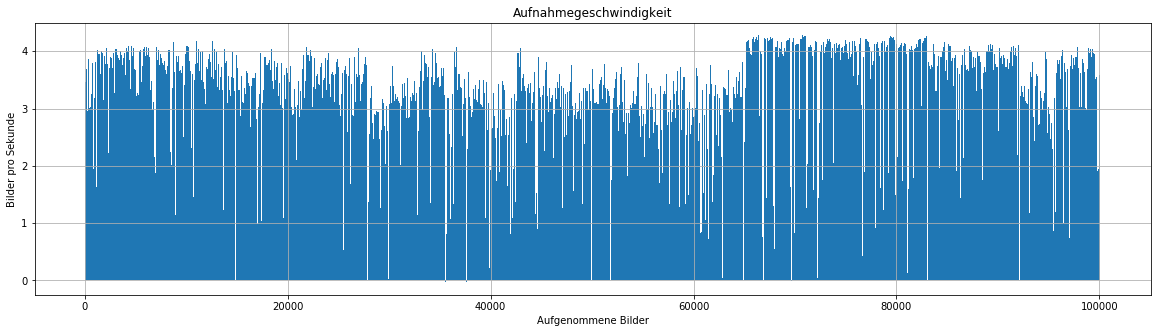

Maximale Bilder pro Sekunde: 4.27679411513


In [11]:
# Für 100 Bilder wird je ein Datenpunkt geplotet mit der Aufnahmegeschwindigkeit 
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(imagesCaptured, imagesPerSecondList,100) #  tick_label=imagesCaptured / für schönere plots, wenn Anzahl der Bilder klein
ax.set(xlabel='Aufgenommene Bilder', ylabel='Bilder pro Sekunde',
       title='Aufnahmegeschwindigkeit')
ax.grid()
fig.savefig("bilderProSekunde.png")
plt.show()
print('Maximale Bilder pro Sekunde: ' + str(max(imagesPerSecondList)))

In [12]:
# Elemente aus Listen entfernen
imagesPerSecondList.clear()
imagesCaptured.clear()

In [13]:
meanMs = sum/imageCounter
imagesPerSecond = imageCounter/(sum/1000)

In [14]:
imagesPerSecond

0.052645810911098594

In [15]:
# Zeitliche nformationen über die gesamten Bilder
print("Anzahl der Bilder: " + str(imageCounter) + "\n" +
    "Mittelwert: " + str(meanMs) + "ms pro Aufnahme" + "\n" +
    "Bilder pro Sekunde: " + str(imagesPerSecond) + "\n" +
     "Maximale Zeitdifferenz zwischen zwei Aufnahmen: " + str(maxDifference) +  "ms" + 
     " (Bild Nr.: " + str(maxDifferenceIndex) + ")" )

Anzahl der Bilder: 100000
Mittelwert: 18994.86365ms pro Aufnahme
Bilder pro Sekunde: 0.0526458109111
Maximale Zeitdifferenz zwischen zwei Aufnahmen: 514939753ms (Bild Nr.: 49832)


## Bildrate mit ohne Unterbrechungen

In diesem Versuch wird die Bildrate für Datensätze berechnet. Dabei werden längere Wartezeiten oder Unterbrechungen zwischen mehreren Datensätzen nicht mit gezählt. 

Datensatz | Bildrate (Bilder pro Sekunde) | Mittelwert: Zeit zwischen Bildaufnahmen in ms | Grenzwert in Sekunden | Anzahl der Bilder | Vergangene Zeit in Stunden | Berechnete Zeit in Stunden für die Aufnahme von 100.000 Bildern
  --- |   ---  | ---       |---|   ---  |     --- | ---     | 
15-22 | 3,451  | 289,7682  | 5 | 100816 |  8,1148 | 8,0491  |
23-24 | 3,579  | 279,4055  | 5 | 22762  | 1,7666  | 7,7613  |
26-27 | 0,8961 | 1115,9179 | 5 | 4912   | 1,5226  | 30,9977 |
28-29 | 1,2763 | 783,5079  | 5 | 6174   | 1,3437  | 21,7641 |
31    | 3,05   | 327,8633  | 5 | 14512  | 1,3216  | 9,1073  |
32    | 3,2678 | 306,0149  | 5 | 12470  | 1,0600  | 8,5004  |
33    | 2,8699 | 348,4490  | 5 | 21780  | 2,1081  | 9,6791  |
34    | 2,938  | 340,3609  | 5 | 14949  | 1,4133  | 9,4545  | 
35    | 1,6492 | 606,3619  | 5 | 11653  | 1,9627  | 16,8434 |
36    | 2,9935 | 334,0557  | 5 | 18494  | 1,7161  | 9,2793  |
37    | 3,2169 | 310,8570  | 5 | 27863  | 2,4059  | 8,6349  |
38    | 3,3058 | 302,4981  | 5 | 35481  | 2,9814  | 8,4027  |
39    | 3,0818 | 324,4807  | 5 | 17527  | 1,5798  | 9,0133  |
40    | 3,0608 | 326,7089  | 5 | 13120  | 1,1908  | 9,0752  |
Tabelle 1: Bildrate für verschiedene Datensätze ohne Unterbrechungen

In [4]:
# Für einen Datensatz soll ohne Unterbrechung, wie z.B. eine Ampel, die Anzahl der Bilder pro Sekunde berechnet werden
i = startIndex
lastValueMs = featuresDf['Zeitstempel in Unixzeit'].iloc[i]
valueMs = 0
# Zeitliche Differenz zwischen zwei Aufnahmen
differenceValueTemp = 0
# Maximale Differenz, welche unter der variablen thresholdMax liegt 
maxDifference = 0
# Minimale Differenz zwischen den Zeitstempeln der Bildaufnahme
minDifference = 100000
# längste Zeitdifferenz t zwischen zwei Zeitstempeln kleiner als der Grenzwert
maxDiffLessThanThreshold = 0
# Das erste Bild wird nicht mit einbezogen in die Berechnung
imageCounter = 0
sum = 0
stopIndex = featuresDf.shape[0]-2
while i <= stopIndex:
    valueMs = featuresDf['Zeitstempel in Unixzeit'].iloc[i+1]
    differenceValueTemp = abs(valueMs - lastValueMs)
    lastValueMs = valueMs
    if differenceValueTemp < minDifference:
        minDifference = differenceValueTemp
    if differenceValueTemp > 5000:
        i = i + 1
        continue
    if differenceValueTemp > maxDiffLessThanThreshold:
        maxDiffLessThanThreshold = differenceValueTemp
    sum = sum + differenceValueTemp
    imageCounter = imageCounter + 1
    i = i + 1
fps = imageCounter/(sum/1000)
pastHours = (imageCounter / fps) / 3600
pastHoursFor100000Images = (100000 / fps) / 3600 
meanImageTime= sum/imageCounter 
print('Anzahl der vergangenen ms: ' + str(sum))
print('Anzahl der Bilder: ' + str(imageCounter))
print('Bildrate (Bilder pro Sekunde): ' + str(fps))
print('Mittelwert: Zeit zwischen Bildaufnahmen in ms: ' + str(meanImageTime))
print('Minimale Dauer: Zeit zwischen Bildaufnahmen in ms: ' + str(minDifference))
print('Vergangene Zeit in Stunden: ' + str(pastHours))
print('Optimale Zeit in Stunden für die Aufnahme von 100.000 Bildern: ' + str(pastHoursFor100000Images))

Anzahl der vergangenen ms: 4286421
Anzahl der Bilder: 13120
Bildrate (Bilder pro Sekunde): 3.0608286027
Mittelwert: Zeit zwischen Bildaufnahmen in ms: 326.708917683
Minimale Dauer: Zeit zwischen Bildaufnahmen in ms: 216
Vergangene Zeit in Stunden: 1.1906725
Optimale Zeit in Stunden für die Aufnahme von 100.000 Bildern: 9.07524771341


In [11]:
maxDiffLessThanThreshold

989